# Abstract Art Generator using GANs

## Initial-Setup

In [ ]:
!nvidia-smi

Sun Jul 25 08:56:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data Gathering

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sayannath2350","key":"a06037980919686feec73218553a329e"}'}

In [ ]:
!mkdir ~p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#Change the permission
!chmod 600 ~/.kaggle/kaggle.json

#Download the Dataset
!kaggle datasets download -d bryanb/abstract-art-gallery

#Unzipping the data
!unzip -q abstract-art-gallery.zip

#Rename the Directory
!mv Abstract_gallery/ dataset/

#Make a directory for saved_models
!mkdir saved_models

#Make a directory for saving the demo images
!mkdir samples

 98% 406M/415M [00:02<00:00, 168MB/s]
100% 415M/415M [00:02<00:00, 154MB/s]


## Import the necessary modules

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

#Setting SEEDS
SEEDS = 42
tf.random.set_seed(SEEDS)
np.random.seed(SEEDS)
w_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

627.1772106398274
629.527677929547


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


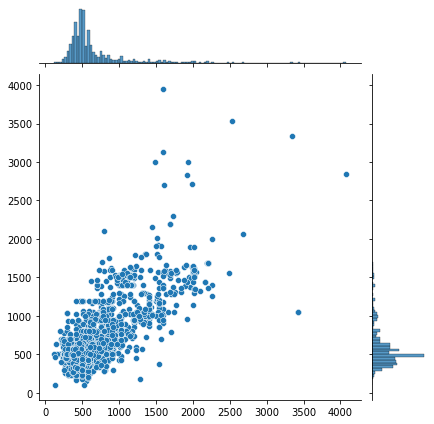

In [ ]:
dim1 = []
dim2 = []

train_dir = 'dataset'

for image_filename in os.listdir(train_dir):
    
    img = mpimg.imread(train_dir +'/'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

print(np.mean(dim1))
print(np.mean(dim2))

sns.jointplot(dim1,dim2)

## Define the Hyperparameters

In [ ]:
IMG_HEIGHT=256
IMG_WIDTH=256
IMG_CHANNELS=3
BATCH_SIZE=128
LATENT_DIM=128
EPOCHS=100
AUTO=tf.data.AUTOTUNE

## Data EDA

In [ ]:
#Determining the length of the dataset
images_path = glob('dataset/*')
print("Number of Images: ", len(images_path))

Number of Images:  2782


## Dataloader

In [ ]:
#Loading Images
@tf.function 
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image)
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    image = tf.cast(image, tf.float32)
    image = (image - 127.5)/ 127.5
    return image

#Shuffle Dataset
@tf.function
def shuffle_dataset(image_path):
    dataset = tf.data.Dataset.from_tensor_slices(image_path)
    dataset = dataset.shuffle(buffer_size=1024)
    dataset = dataset.map(load_image, num_parallel_calls=AUTO)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTO)
    return dataset

## Setting up Pipeline

In [ ]:
dataset = shuffle_dataset(images_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


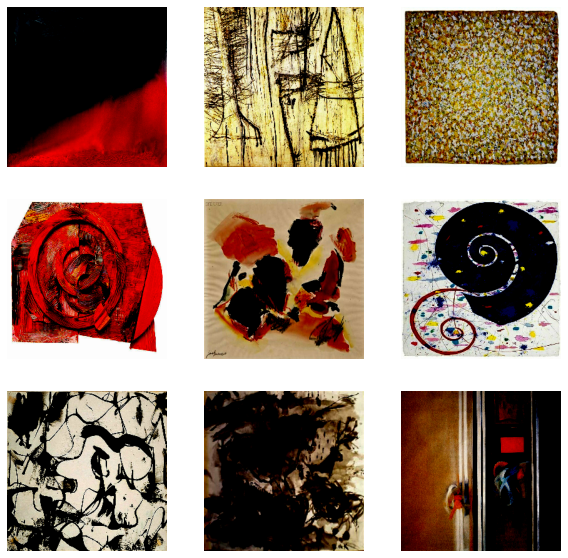

In [ ]:
image_batch = next(iter(dataset))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i])
    plt.axis("off")

In [ ]:
def deconv_block(inputs, num_filters, kernel_size, strides, bn=True):
    x = layers.Conv2DTranspose(
        filters=num_filters,
        kernel_size=kernel_size,
        kernel_initializer=w_init,
        padding="same",
        strides=strides,
        use_bias=False
        )(inputs)

    if bn:
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
    return x


def conv_block(inputs, num_filters, kernel_size, padding="same", strides=2, activation=True):
    x = layers.Conv2D(
        filters=num_filters,
        kernel_size=kernel_size,
        kernel_initializer=w_init,
        padding=padding,
        strides=strides,
    )(inputs)

    if activation:
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Dropout(0.3)(x)
    return x

## Build the Discriminator

In [ ]:
def get_discriminator_model():
    f = [2**i for i in range(4)]
    image_input = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    x = image_input
    filters = 64
    output_strides = 16
    h_output = IMG_HEIGHT // output_strides
    w_output = IMG_WIDTH // output_strides

    for i in range(0, 4):
        x = conv_block(x, num_filters=f[i] * filters, kernel_size=5, strides=2)

    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)

    return tf.keras.models.Model(image_input, x, name="discriminator")

In [ ]:
discriminator = get_discriminator_model()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      4864      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 128)     

In [ ]:
def get_generator_model(latent_dim):
    f = [2**i for i in range(5)][::-1]
    filters = 32
    output_strides = 16
    h_output = IMG_HEIGHT // output_strides
    w_output = IMG_WIDTH // output_strides

    noise = layers.Input(shape=(latent_dim,), name="generator_noise_input")

    x = layers.Dense(f[0] * filters * h_output * w_output, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Reshape((h_output, w_output, 16 * filters))(x)

    for i in range(1, 5):
        x = deconv_block(x,
            num_filters=f[i] * filters,
            kernel_size=5,
            strides=2,
            bn=True
        )

    x = conv_block(x,
        num_filters=3,  ## Change this to 1 for grayscale.
        kernel_size=5,
        strides=1,
        activation=False
    )
    fake_output = layers.Activation("tanh")(x)

    return tf.keras.models.Model(noise, fake_output, name="generator")

In [ ]:
generator = get_generator_model(LATENT_DIM)
generator.summary() 

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_noise_input (Input [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 131072)            16777216  
_________________________________________________________________
batch_normalization (BatchNo (None, 131072)            524288    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 131072)            0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)       3276800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 256)       10

## Plot the Images

In [ ]:
def save_plot(examples, epoch, n):
    examples = (examples + 1) / 2.0
    for i in range(n * n):
        plt.subplot(n, n, i+1)
        plt.axis("off")
        plt.imshow(examples[i]) 
    filename = f"/content/samples/demo-{epoch+1}.png"
    plt.savefig(filename)
    plt.close()

## Build the `GANs` Model

In [ ]:
class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for _ in range(2):
            ## Train the discriminator
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            generated_images = self.generator(random_latent_vectors)
            generated_labels = tf.zeros((batch_size, 1))

            with tf.GradientTape() as ftape:
                predictions = self.discriminator(generated_images)
                d1_loss = self.loss_fn(generated_labels, predictions)
            grads = ftape.gradient(d1_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

            ## Train the discriminator
            labels = tf.ones((batch_size, 1))

            with tf.GradientTape() as rtape:
                predictions = self.discriminator(real_images)
                d2_loss = self.loss_fn(labels, predictions)
            grads = rtape.gradient(d2_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        ## Train the generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as gtape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = gtape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {"d1_loss": d1_loss, "d2_loss": d2_loss, "g_loss": g_loss}

In [ ]:
gan = GAN(discriminator, generator, LATENT_DIM)

## Compile the Model

In [ ]:
bce_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
gan.compile(d_optimizer, g_optimizer, bce_loss_fn)

In [ ]:
for epoch in range(EPOCHS):
        gan.fit(dataset, epochs=25)
        generator.save("/content/saved_models/g_model.h5")
        discriminator.save("/content/saved_models/d_model.h5")

        n_samples = 25
        noise = np.random.normal(size=(n_samples, BATCH_SIZE))
        examples = generator.predict(noise)
        save_plot(examples, epoch, int(np.sqrt(n_samples)))

Epoch 1/25
22/22 [==============================] - 56s 2s/step - d1_loss: 0.4217 - d2_loss: 0.4210 - g_loss: 2.4874
Epoch 2/25
22/22 [==============================] - 54s 2s/step - d1_loss: 0.3072 - d2_loss: 0.4021 - g_loss: 2.4195
Epoch 3/25
22/22 [==============================] - 54s 2s/step - d1_loss: 0.2360 - d2_loss: 0.3187 - g_loss: 2.2597
Epoch 4/25
22/22 [==============================] - 54s 2s/step - d1_loss: 0.2290 - d2_loss: 0.3055 - g_loss: 2.5332
Epoch 5/25
22/22 [==============================] - 54s 2s/step - d1_loss: 0.2280 - d2_loss: 0.2968 - g_loss: 2.4758
Epoch 6/25
22/22 [==============================] - 54s 2s/step - d1_loss: 0.2234 - d2_loss: 0.2661 - g_loss: 2.5207
Epoch 7/25
22/22 [==============================] - 54s 2s/step - d1_loss: 0.2309 - d2_loss: 0.2814 - g_loss: 2.5099
Epoch 8/25
22/22 [==============================] - 54s 2s/step - d1_loss: 0.2181 - d2_loss: 0.2693 - g_loss: 2.5370
Epoch 9/25
22/22 [==============================] - 54s 2s/step 

KeyboardInterrupt: ignored